In [26]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import time

test_image = 'D:/code/yolo8/data/01_raw/paa_12_1/image_0.png'
background_image = 'D:/code/yolo8/data/01_raw/paa_12_1/background_clean.png'
roi = 'D:/code/yolo8/data/01_raw/paa_12_1/roi.csv'


# 2D Profile

Test image shape: (200, 704)
Background image shape: (200, 704)
Spatial domain subtraction time: 79300.0000 nanoseconds
FFT operations total time: 83493398160064.3125 nanoseconds
FFT is 1052880178.6x slower than direct subtraction


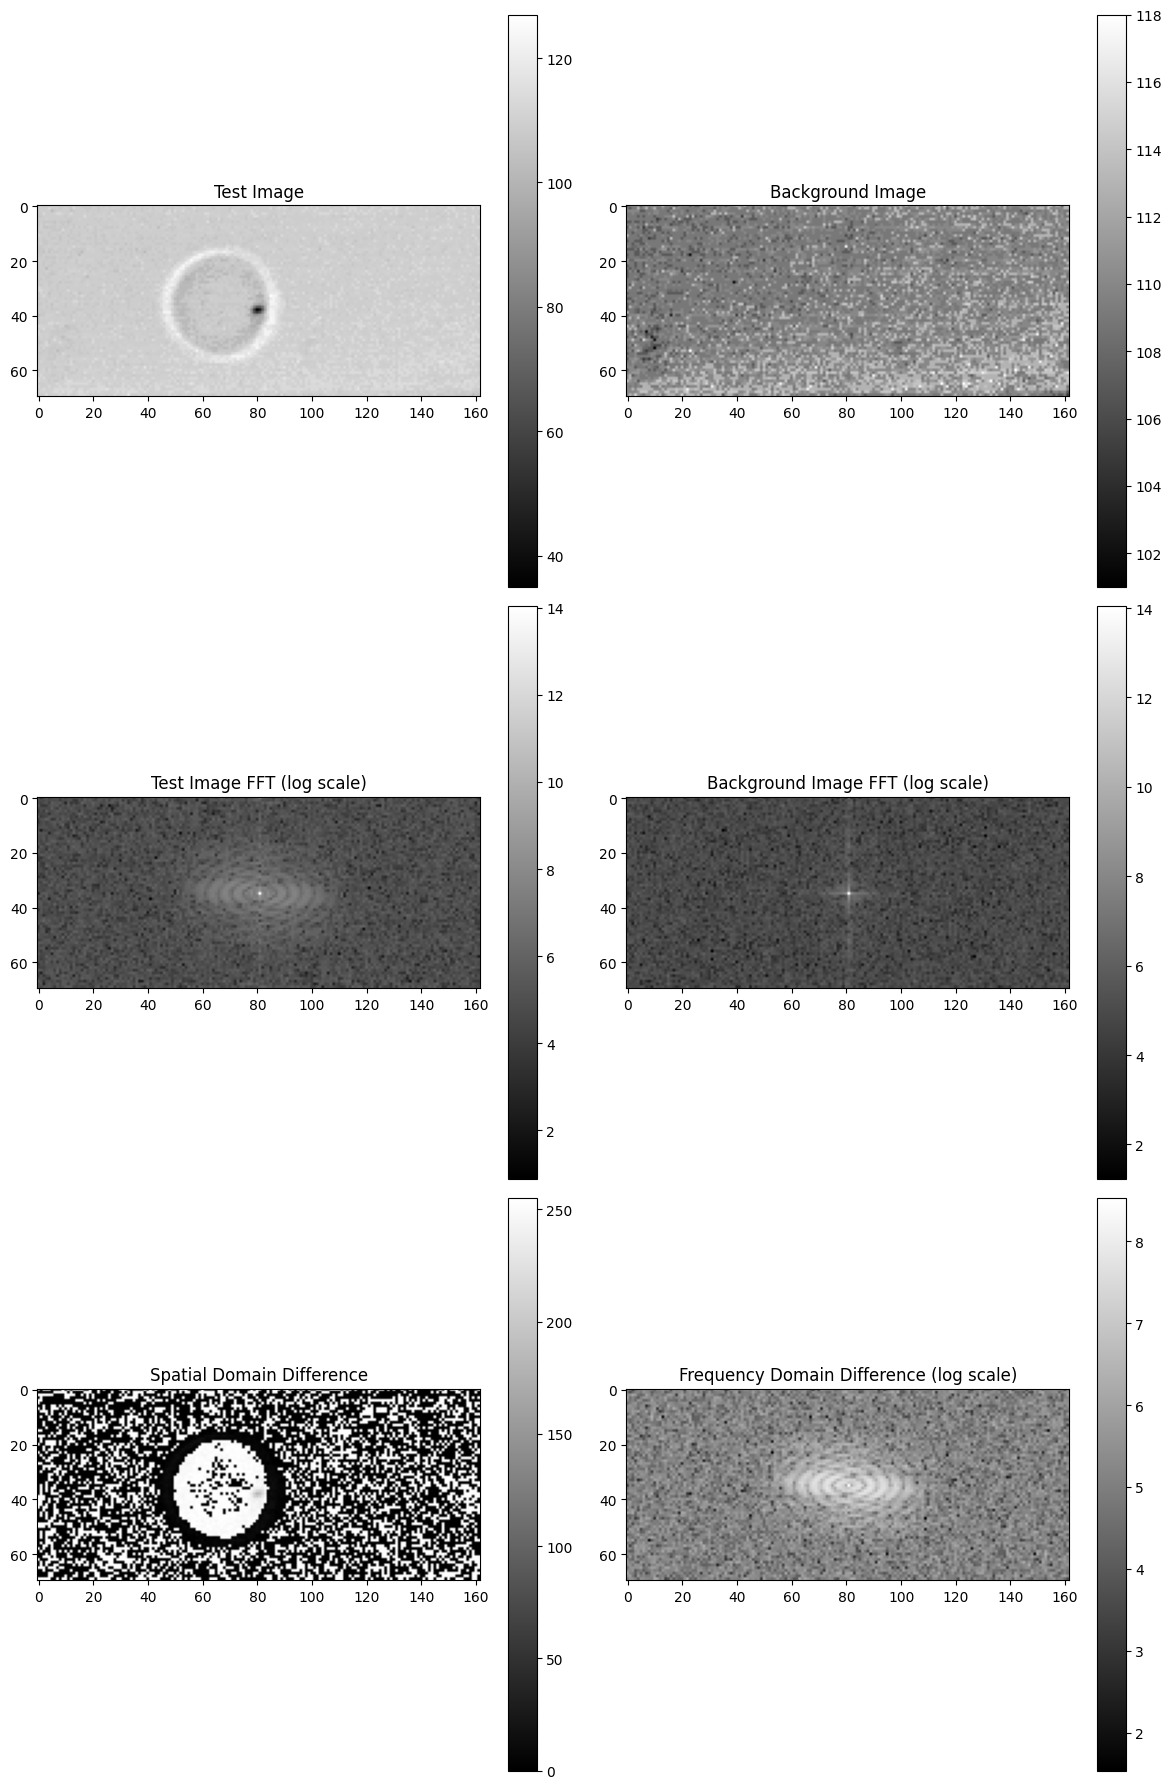

In [29]:

# Load ROI coordinates from CSV
roi_data = np.loadtxt(roi, delimiter=',', skiprows=1)
x, y, width, height = map(int, roi_data)

# Load images directly with OpenCV to maintain original quality
test_array = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)
background_array = cv2.imread(background_image, cv2.IMREAD_GRAYSCALE)

# Print original image dimensions
print(f"Test image shape: {test_array.shape}")
print(f"Background image shape: {background_array.shape}")

# Crop images using ROI
test_array = test_array[y:y+height, x:x+width]
background_array = background_array[y:y+height, x:x+width]

# Time the spatial domain subtraction
start_time = time.perf_counter_ns()
spatial_diff = test_array - background_array
spatial_time = time.perf_counter_ns() - start_time
print(f"Spatial domain subtraction time: {spatial_time:.4f} nanoseconds")

# Time the FFT operations
start_time = time.time()
test_fft = np.fft.fft2(test_array)
background_fft = np.fft.fft2(background_array)
test_fft_shifted = np.fft.fftshift(test_fft)
background_fft_shifted = np.fft.fftshift(background_fft)
diff_fft = test_fft_shifted - background_fft_shifted
fft_time = time.perf_counter_ns() - start_time
print(f"FFT operations total time: {fft_time:.4f} nanoseconds")
print(f"FFT is {fft_time/spatial_time:.1f}x slower than direct subtraction")

diff_fft = test_fft_shifted - background_fft_shifted

# Create figure for visualization
plt.figure(figsize=(12, 18))

# Original images
plt.subplot(321)
plt.imshow(test_array, cmap='gray')
plt.title('Test Image')
plt.colorbar()

plt.subplot(322)
plt.imshow(background_array, cmap='gray')
plt.title('Background Image')
plt.colorbar()

# FFT magnitude plots (log scale for better visualization)
plt.subplot(323)
plt.imshow(np.log(np.abs(test_fft_shifted) + 1), cmap='gray')
plt.title('Test Image FFT (log scale)')
plt.colorbar()

plt.subplot(324)
plt.imshow(np.log(np.abs(background_fft_shifted) + 1), cmap='gray')
plt.title('Background Image FFT (log scale)')
plt.colorbar()

# Difference in spatial and frequency domain
plt.subplot(325)
plt.imshow(test_array - background_array, cmap='gray')
plt.title('Spatial Domain Difference')
plt.colorbar()

plt.subplot(326)
plt.imshow(np.log(np.abs(diff_fft) + 1), cmap='gray')
plt.title('Frequency Domain Difference (log scale)')
plt.colorbar()

plt.tight_layout()
plt.show()

Median spatial domain subtraction time: 10.5 microseconds
Median FFT operations total time: 439.8 microseconds
FFT is 41.9x slower than direct subtraction


C:\Users\gavin\AppData\Local\Temp\ipykernel_22736\3998982148.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([spatial_times, fft_times], labels=['Spatial Domain', 'FFT Domain'])


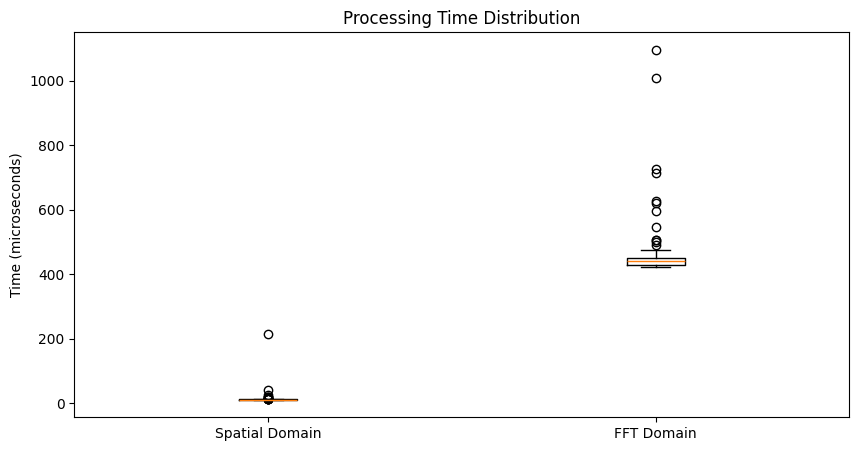

In [30]:
# Time measurements arrays
spatial_times = []
fft_times = []

# Perform 100 iterations
for _ in range(100):
    # Time the spatial domain subtraction
    start_time = time.perf_counter_ns()
    spatial_diff = test_array - background_array
    spatial_times.append((time.perf_counter_ns() - start_time) / 1000)  # Convert to microseconds

    # Time the FFT operations
    start_time = time.perf_counter_ns()
    test_fft = np.fft.fft2(test_array)
    background_fft = np.fft.fft2(background_array)
    test_fft_shifted = np.fft.fftshift(test_fft)
    background_fft_shifted = np.fft.fftshift(background_fft)
    diff_fft = test_fft_shifted - background_fft_shifted
    fft_times.append((time.perf_counter_ns() - start_time) / 1000)  # Convert to microseconds

# Calculate median times
median_spatial = np.median(spatial_times)
median_fft = np.median(fft_times)

print(f"Median spatial domain subtraction time: {median_spatial:,.1f} microseconds")
print(f"Median FFT operations total time: {median_fft:,.1f} microseconds")
print(f"FFT is {median_fft/median_spatial:.1f}x slower than direct subtraction")

# Optional: Show distribution of times
plt.figure(figsize=(10, 5))
plt.boxplot([spatial_times, fft_times], labels=['Spatial Domain', 'FFT Domain'])
plt.title('Processing Time Distribution')
plt.ylabel('Time (microseconds)')
plt.show()

Each of these algorithms serves different purposes:
DCT: Used in JPEG compression
SVD: Useful for image compression and denoising
Gabor Filters: Good for texture analysis and feature extraction
Hough Transform: Excellent for geometric shape detection
Watershed: Powerful for image segmentation
SIFT/SURF/ORB: Great for feature detection and matching
Contour Detection: Useful for object detection and shape analysis
PCA: Good for dimensionality reduction and feature extraction
To visualize results, you can use matplotlib similar to your FFT and DWT implementations. Let me know if you'd like to see specific visualization code for any of these algorithms!

Processing Background Image ROI...


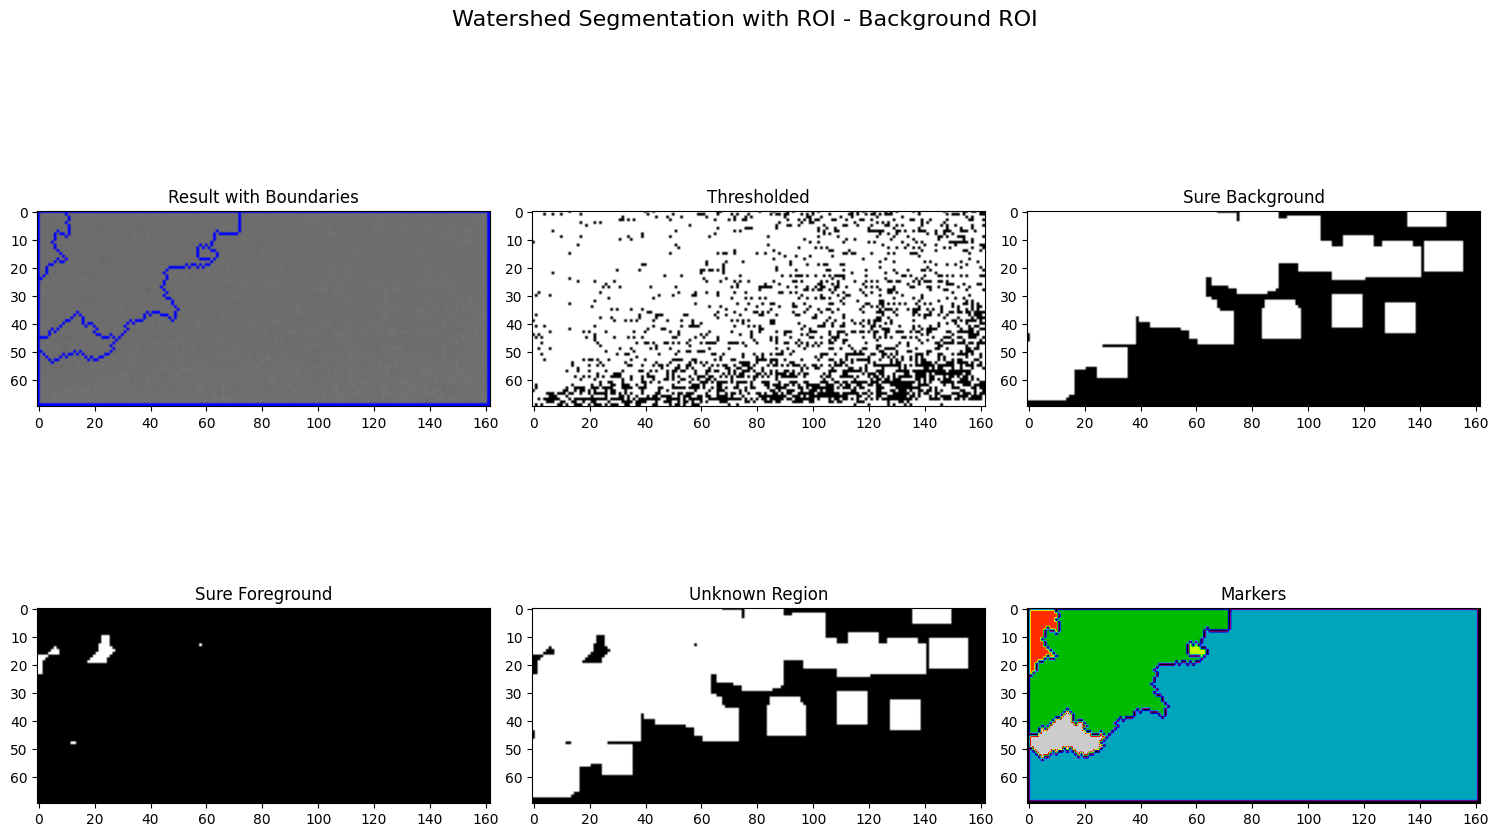


Processing Target Image ROI...


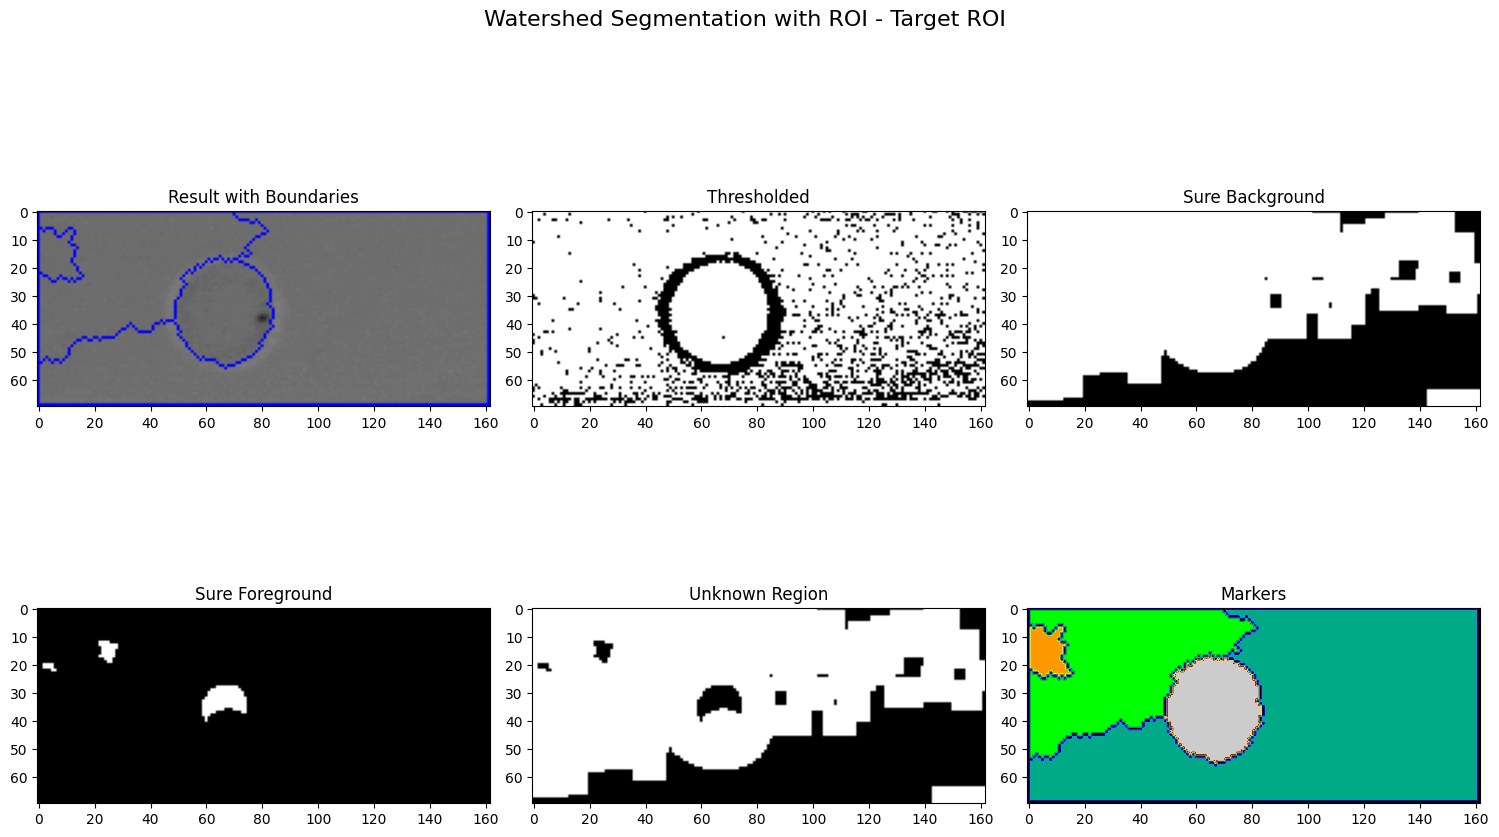

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_watershed_with_roi(image, title):
    # Make a copy of the image
    img_copy = image.copy()
    
    # Convert to gray
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Noise removal using morphological operations
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown==255] = 0
    
    # Apply watershed
    markers = cv2.watershed(img_copy, markers)
    img_copy[markers == -1] = [255, 0, 0]  # Mark watershed boundaries in red
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Watershed Segmentation with ROI - {title}', fontsize=16)
    
    axes[0, 0].imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('Result with Boundaries')
    
    axes[0, 1].imshow(thresh, cmap='gray')
    axes[0, 1].set_title('Thresholded')
    
    axes[0, 2].imshow(sure_bg, cmap='gray')
    axes[0, 2].set_title('Sure Background')
    
    axes[1, 0].imshow(sure_fg, cmap='gray')
    axes[1, 0].set_title('Sure Foreground')
    
    axes[1, 1].imshow(unknown, cmap='gray')
    axes[1, 1].set_title('Unknown Region')
    
    axes[1, 2].imshow(markers, cmap='nipy_spectral')
    axes[1, 2].set_title('Markers')
    
    plt.tight_layout()
    plt.show()
    
    return markers, img_copy

def process_images_with_roi(background_img, target_img, roi=None):
    """
    Process images with optional ROI
    roi: tuple of (x, y, width, height) for cropping
    """
    if roi is None:
        # If no ROI specified, use the entire image
        roi = (0, 0, background_img.shape[1], background_img.shape[0])
    
    # Crop images according to ROI
    x, y, w, h = roi
    background_roi = background_img[y:y+h, x:x+w]
    target_roi = target_img[y:y+h, x:x+w]
    
    # Apply watershed to both ROIs
    print("Processing Background Image ROI...")
    bg_markers, bg_result = apply_watershed_with_roi(background_roi, "Background ROI")
    
    print("\nProcessing Target Image ROI...")
    target_markers, target_result = apply_watershed_with_roi(target_roi, "Target ROI")
    
    return bg_markers, target_markers, bg_result, target_result

# Example usage
def main(background_array, target_array, roi=None):
    try:
        # Convert arrays to BGR if they're not already
        if len(background_array.shape) == 2:  # If grayscale
            background_img = cv2.cvtColor(background_array, cv2.COLOR_GRAY2BGR)
            target_img = cv2.cvtColor(target_array, cv2.COLOR_GRAY2BGR)
        else:
            background_img = background_array
            target_img = target_array
        
        # Process the images
        bg_markers, target_markers, bg_result, target_result = process_images_with_roi(
            background_img, 
            target_img,
            roi
        )
        
        return bg_markers, target_markers, bg_result, target_result
        
    except Exception as e:
        print(f"Error processing images: {str(e)}")
        return None

# Use the function with your arrays
# Example ROI: (x, y, width, height)
# roi = (100, 100, 300, 300)  # Adjust these values based on your needs
results = main(background_array, test_array)

Comparing all feature detection methods...

Processing SIFT...


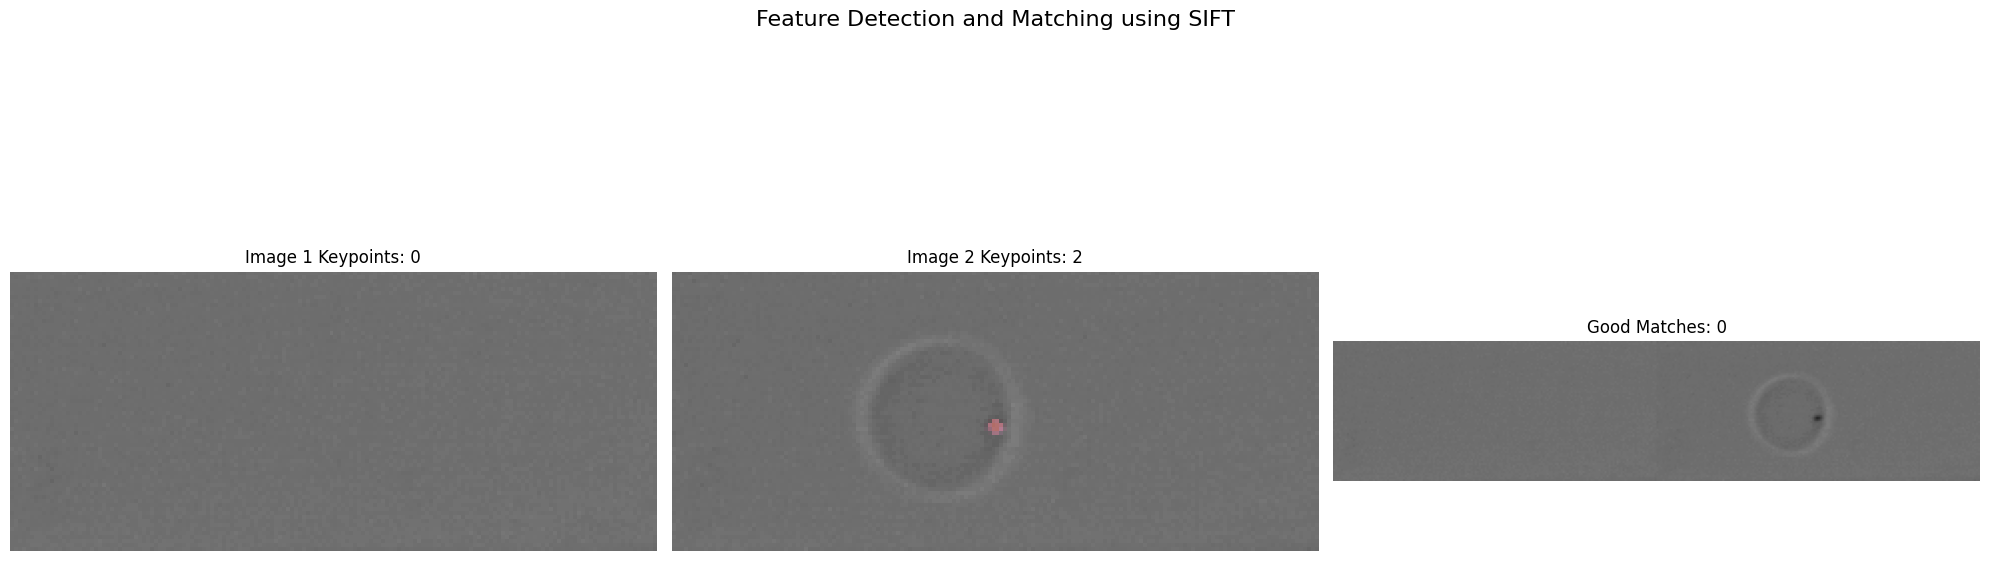

Number of keypoints in image 1: 0
Number of keypoints in image 2: 2
Number of good matches: 0

Processing ORB...


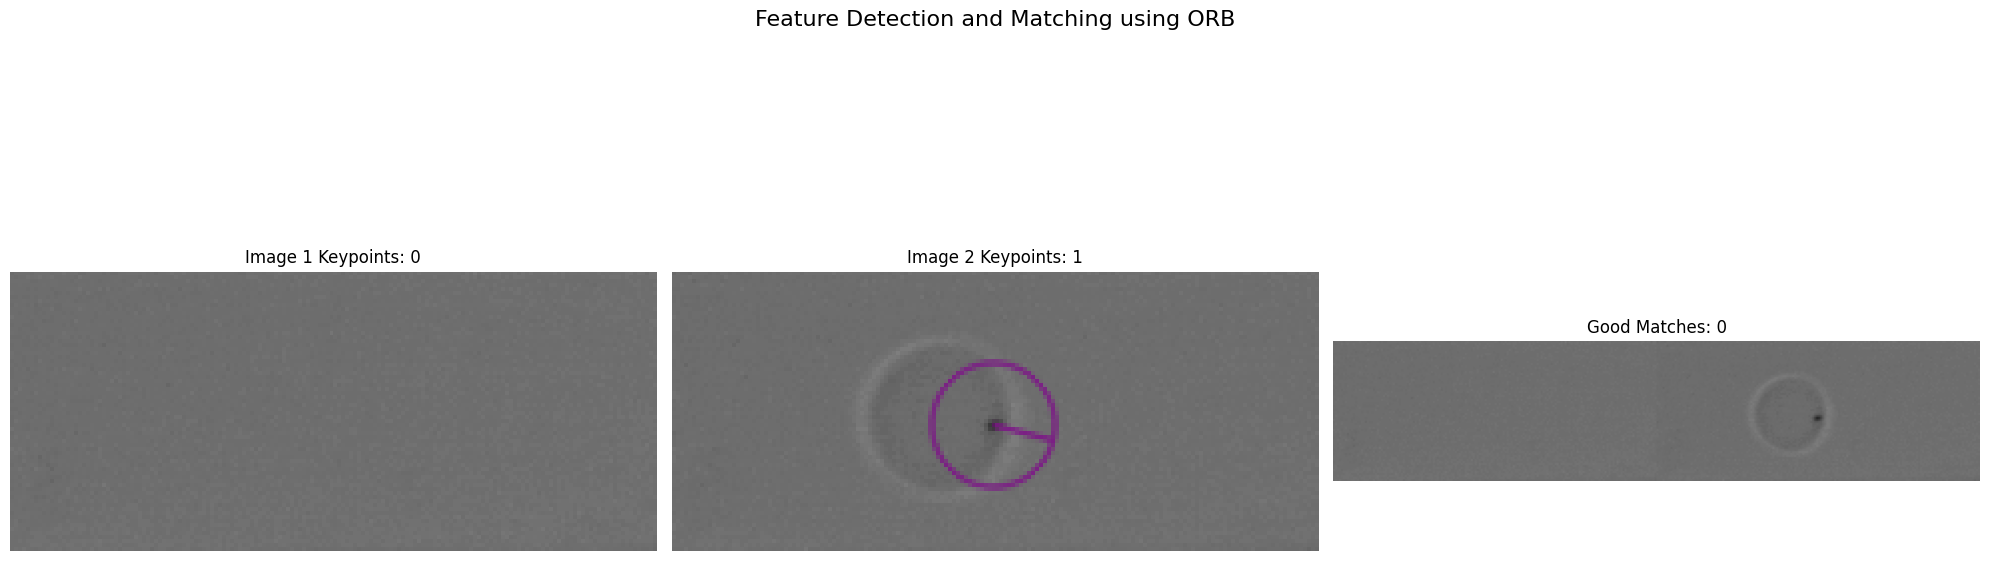

Number of keypoints in image 1: 0
Number of keypoints in image 2: 1
Number of good matches: 0

Finding transformation between images...


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'cv::findHomography'


In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_match_features(img1, img2, method='sift', plot=True):
    """
    Detect and match features between two images using specified method
    
    Parameters:
    img1, img2: Input images
    method: 'sift', 'surf', or 'orb'
    plot: Boolean to control visualization
    """
    
    # Convert images to grayscale
    if len(img1.shape) == 3:
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    else:
        gray1, gray2 = img1, img2

    # Initialize detector and matcher based on method
    if method.lower() == 'sift':
        detector = cv2.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    elif method.lower() == 'surf':
        detector = cv2.SURF_create()  # Note: SURF is patented and might not be available
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    elif method.lower() == 'orb':
        detector = cv2.ORB_create(nfeatures=2000)
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else:
        raise ValueError("Method must be 'sift', 'surf', or 'orb'")

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = detector.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(gray2, None)

    # Match descriptors
    matches = matcher.match(descriptors1, descriptors2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Keep only good matches
    good_matches = matches[:50]  # Adjust this number based on your needs

    if plot:
        # Prepare visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
        fig.suptitle(f'Feature Detection and Matching using {method.upper()}', fontsize=16)

        # Draw keypoints on both images
        img1_kp = cv2.drawKeypoints(gray1, keypoints1, None, 
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        img2_kp = cv2.drawKeypoints(gray2, keypoints2, None, 
                                   flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        # Draw matches
        img_matches = cv2.drawMatches(gray1, keypoints1, gray2, keypoints2, good_matches, None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

        # Display results
        ax1.imshow(img1_kp)
        ax1.set_title(f'Image 1 Keypoints: {len(keypoints1)}')
        ax1.axis('off')

        ax2.imshow(img2_kp)
        ax2.set_title(f'Image 2 Keypoints: {len(keypoints2)}')
        ax2.axis('off')

        ax3.imshow(img_matches)
        ax3.set_title(f'Good Matches: {len(good_matches)}')
        ax3.axis('off')

        plt.tight_layout()
        plt.show()

    return keypoints1, keypoints2, good_matches

def compare_methods(img1, img2):
    """
    Compare all feature detection methods
    """
    methods = ['sift', 'orb']  # Add 'surf' if available
    
    for method in methods:
        print(f"\nProcessing {method.upper()}...")
        try:
            keypoints1, keypoints2, matches = detect_and_match_features(img1, img2, method=method)
            print(f"Number of keypoints in image 1: {len(keypoints1)}")
            print(f"Number of keypoints in image 2: {len(keypoints2)}")
            print(f"Number of good matches: {len(matches)}")
        except Exception as e:
            print(f"Error processing {method}: {str(e)}")

# Function to calculate homography and find transformation
def find_transformation(img1, img2, method='sift'):
    """
    Find transformation between images using feature matching
    Returns homography matrix
    """
    # Detect and match features
    keypoints1, keypoints2, good_matches = detect_and_match_features(img1, img2, method, plot=False)
    
    # Extract location of good matches
    points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
    points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

    for i, match in enumerate(good_matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    
    return H, mask

# Example usage
def main(background_array, target_array):
    """
    Main function to process images
    """
    print("Comparing all feature detection methods...")
    compare_methods(background_array, target_array)
    
    print("\nFinding transformation between images...")
    H, mask = find_transformation(background_array, target_array)
    
    return H, mask

# Use the code
H, mask = main(background_array, test_array)